#LIBRARY REQUIREMENTS

In [ ]:
!pip install mediapipe

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import pandas as pd
import os
from os import path

#DATASET

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_1=pd.read_csv('/content/drive/MyDrive/mediapipe_bendshape_data/bendshapes_for_training.csv')
data_2=pd.read_csv('/content/drive/MyDrive/mediapipe_bendshape_data/bendshapes_train.csv')
data_3=pd.read_csv('/content/drive/MyDrive/mediapipe_bendshape_data/bendshapes_for_validating.csv.csv')
data_4=pd.read_csv('/content/drive/MyDrive/mediapipe_bendshape_data/bendshapes_for_testing.csv')
data_5=pd.read_csv('/content/drive/MyDrive/mediapipe_bendshape_data/bendshapes_test.csv')
dataset=pd.concat([data_1,data_2,data_3,data_4,data_5], ignore_index=True)

In [ ]:
dataset=dataset[dataset['label']!='surprise']

In [ ]:
label_mapping = {'neutral': 2, 'anger': 0, 'disgust': 0, 'fear': 0, 'happy': 1, 'sad': 0}
dataset['label'] = dataset['label'].map(label_mapping)

In [ ]:
value_counts = dataset['label'].value_counts()

fig = go.Figure(data=[go.Bar(x=np.array(value_counts.index), y=np.array(value_counts))])

fig.update_layout(
    margin=dict(l=80, r=50, t=100, b=50),
    height=500,
    width=500,
    title='THE NUMBER OF OBSERVATIONS ON 7 CATEGORIES',
    xaxis_title='Label',
    yaxis_title='Observations',
    xaxis=dict(tickfont=dict(size=12)),
    yaxis=dict(tickfont=dict(size=12)),
    showlegend=False,
    font=dict(family='Georgia', size=12))

fig.show()

In [ ]:
positive_count = dataset['label'].eq(1).sum()
negative_count = dataset['label'].eq(0).sum()
neutral_count = dataset['label'].eq(2).sum()

diff = positive_count - neutral_count

if diff > 0:
    negative_indices = dataset.index[dataset['label'] == 1]
    random_negative_indices = np.random.choice(negative_indices, size=diff, replace=False)
    dataset = dataset.drop(random_negative_indices)

In [ ]:
positive_columns = dataset[dataset['label'] == 1].median().nlargest(31).index
negative_columns=dataset[dataset['label'] == 0].median().nlargest(30).index
neutral_columns=dataset[dataset['label'] == 2].median().nlargest(31).index

In [ ]:
columns=[]
for i in positive_columns:
    columns.append(i)
for i in negative_columns:
    if i in columns:
        continue
    else:
        columns.append(i)
for i in neutral_columns:
    if i in columns:
        continue
    else:
        columns.append(i)

In [ ]:
columns

['label',
 'mouthSmileRight',
 'mouthSmileLeft',
 'eyeSquintLeft',
 'eyeSquintRight',
 'eyeLookDownRight',
 'mouthUpperUpRight',
 'eyeBlinkLeft',
 'eyeLookDownLeft',
 'mouthUpperUpLeft',
 'eyeBlinkRight',
 'mouthLowerDownRight',
 'eyeLookInRight',
 'eyeLookOutLeft',
 'mouthLowerDownLeft',
 'browOuterUpLeft',
 'eyeLookUpLeft',
 'mouthStretchRight',
 'browOuterUpRight',
 'eyeLookUpRight',
 'eyeLookInLeft',
 'eyeLookOutRight',
 'mouthStretchLeft',
 'browInnerUp',
 'mouthPressRight',
 'browDownRight',
 'mouthPressLeft',
 'browDownLeft',
 'jawOpen',
 'mouthShrugUpper',
 'mouthFunnel',
 'mouthPucker',
 'mouthRollLower',
 'mouthShrugLower',
 'eyeWideLeft',
 'mouthRollUpper',
 'eyeWideRight',
 'mouthFrownRight']

In [ ]:
dataset=dataset[columns]

In [ ]:
dataset.shape

(67426, 38)

In [ ]:
x = dataset.drop("label", axis=1)
y = dataset["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

#TRAINING

In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((37, )),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               19456     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint('trang_xinh_32.h5', save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10, verbose=1)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00003)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=tf.keras.metrics.CategoricalAccuracy(name='accuracy')
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot)).batch(32)

history=model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=250,
    verbose=1,
    callbacks=[cp_callback, es_callback],
    shuffle=True
)

Epoch 1/250
1686/1686 [==============================] - 14s 7ms/step - loss: 0.8870 - accuracy: 0.6049 - val_loss: 0.7975 - val_accuracy: 0.6114
Epoch 2/250
1686/1686 [==============================] - 12s 7ms/step - loss: 0.8054 - accuracy: 0.6321 - val_loss: 0.7550 - val_accuracy: 0.7385
Epoch 3/250
1686/1686 [==============================] - 12s 7ms/step - loss: 0.7742 - accuracy: 0.7124 - val_loss: 0.7362 - val_accuracy: 0.7368
Epoch 4/250
1686/1686 [==============================] - 12s 7ms/step - loss: 0.7539 - accuracy: 0.7272 - val_loss: 0.7226 - val_accuracy: 0.7368
Epoch 5/250
1686/1686 [==============================] - 11s 7ms/step - loss: 0.7395 - accuracy: 0.7296 - val_loss: 0.7105 - val_accuracy: 0.7379
Epoch 6/250
1686/1686 [==============================] - 11s 7ms/step - loss: 0.7265 - accuracy: 0.7317 - val_loss: 0.7024 - val_accuracy: 0.7405
Epoch 7/250
1686/1686 [==============================] - 11s 7ms/step - loss: 0.7162 - accuracy: 0.7330 - val_loss: 0.6876 -

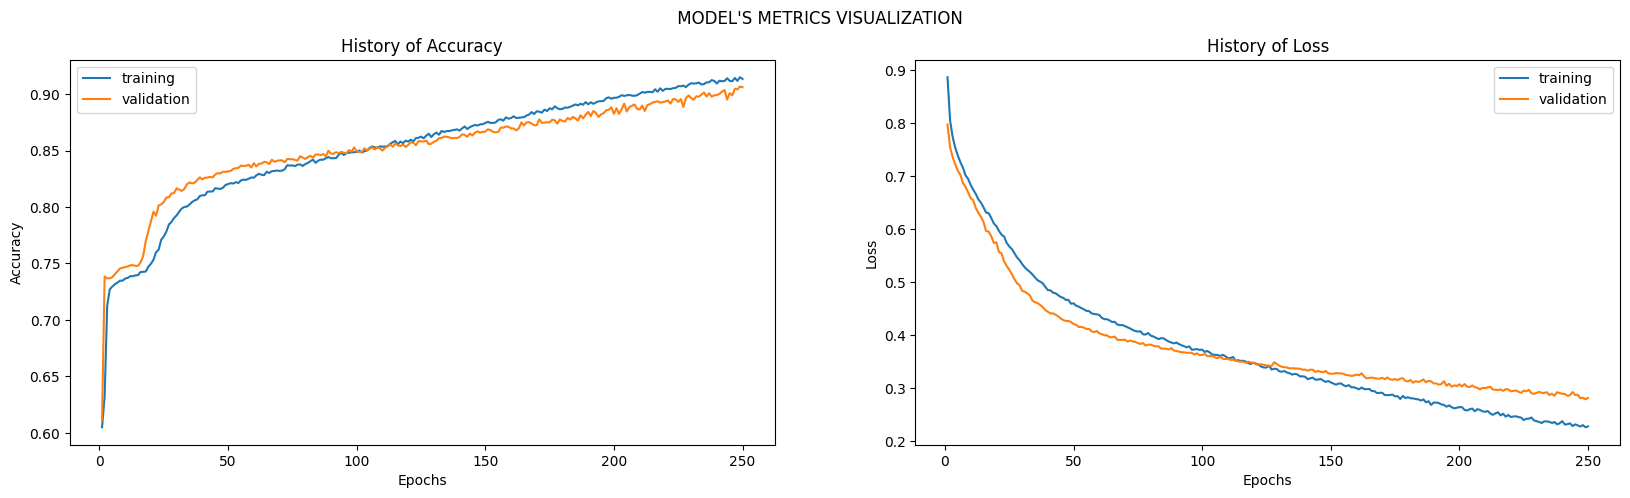

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)

    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

Train_Val_Plot(
        history.history['accuracy'],history.history['val_accuracy'],
        history.history['loss'],history.history['val_loss']
              )

422/422 [==============================] - 1s 2ms/step


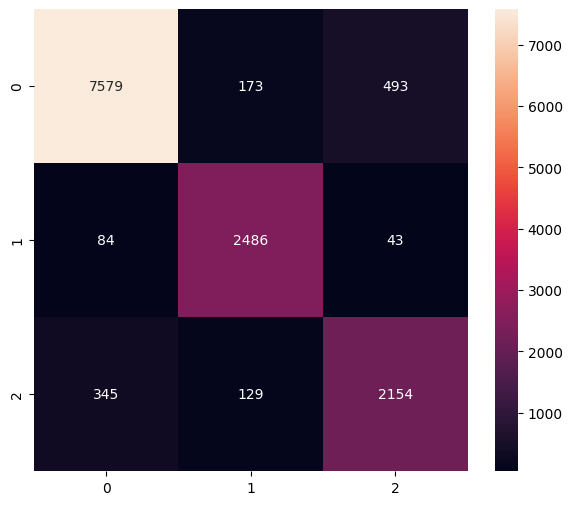

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      8245
           1       0.89      0.95      0.92      2613
           2       0.80      0.82      0.81      2628

    accuracy                           0.91     13486
   macro avg       0.88      0.90      0.89     13486
weighted avg       0.91      0.91      0.91     13486



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

#EVALUATING

In [ ]:
df_real_test=pd.DataFrame()

base_options = python.BaseOptions(model_asset_path="/content/drive/MyDrive/mediapipe_bendshape_data/face_landmarker.task")
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

W0000 00:00:1699386515.651116      33 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


In [ ]:
root_folder = "/content/drive/MyDrive/mediapipe_bendshape_data/anhtest.zip"

for root, dirs, files in os.walk(root_folder):
    if path.basename(root) == "surprise":
        continue

    for filename in files:
        if filename.endswith(".jpg"):
            image_path = path.join(root, filename)
            image = mp.Image.create_from_file(image_path)
            detection_result = detector.detect(image)
            category_dict = {}
            for category_list in detection_result.face_blendshapes:
                for category in category_list:
                    category_dict[category.category_name] = category.score
            category_dict['label'] = path.basename(root)
            df_temp = pd.DataFrame(category_dict, index=[0])
            df_real_test = pd.concat([df_real_test, df_temp], ignore_index=True)

In [ ]:
df_real_test_copy=df_real_test.copy()

In [ ]:
label_mapping = {'neutral': 2, 'anger': 0, 'disgust': 0, 'fear': 0, 'happy': 1, 'sad': 0}
df_real_test_copy['label'] = df_real_test_copy['label'].map(label_mapping)

In [ ]:
df_real_test_copy=df_real_test_copy[columns]

In [ ]:
x_real_test = df_real_test_copy.drop(['label'], axis=1)
y_real_test = df_real_test_copy['label']
y_test_one_hot = to_categorical(y_real_test, num_classes=3)

In [ ]:
neutral_indices = df_real_test.index[df_real_test['label'] == 'neutral'].tolist()
print(neutral_indices)

[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [ ]:
predictions = []

for i in range(22, 39):
    sample = np.array([x_real_test.iloc[i]])
    prediction = model.predict(sample)
    predictions.append(prediction)

1/1 [==============================] - 0s 22ms/step


In [ ]:
label_mapping = {0: 'negative', 1: 'positive',2:'neutral'}

for i, prediction in enumerate(predictions):
    predicted_class_index = np.argmax(prediction)
    class_label = label_mapping.get(predicted_class_index, "Unknown")
    print(f"Image {i + 1}: Predicted Class: {class_label}")

Image 1: Predicted Class: neutral
Image 2: Predicted Class: neutral
Image 3: Predicted Class: neutral
Image 4: Predicted Class: neutral
Image 5: Predicted Class: neutral
Image 6: Predicted Class: neutral
Image 7: Predicted Class: neutral
Image 8: Predicted Class: negative
Image 9: Predicted Class: neutral
Image 10: Predicted Class: neutral
Image 11: Predicted Class: neutral
Image 12: Predicted Class: neutral
Image 13: Predicted Class: neutral
Image 14: Predicted Class: neutral
Image 15: Predicted Class: negative
Image 16: Predicted Class: neutral
Image 17: Predicted Class: neutral
